In [215]:
# Todo: balance dataset?
# Add better markdown labels for sections in the first lab?
# add maxlen & max_words back? 
# add test_size to the hyperparameter explanation? (both for lab 1 and 2)

# is Embedding(max_words, 32, input_length=maxlen) correct?

# remove stopwords?
# lemmetize?

# why embedding layer?

# Sentiment Analysis

In [269]:
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [ ]:
max_words = 1000  # Consider only the top 1000 words
maxlen = 100  # Set the maximum length of sequences to 100

In [225]:
data = pd.read_csv('emotions.csv')

display(
    data,
    print(data['label'].unique())
)

['anger' 'sadness' 'joy' 'love' 'fear' 'surprise']


,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness
...,...,...
19995,i was i might be buying stuff from there but i...,joy
19996,i like sonam deepika and genelia who i feel ar...,joy
19997,i feel pathetic that i can hardly go a whole d...,sadness
19998,id have spent more time with her on reading i ...,sadness


None

### Misc data exploration

In [226]:
# Find the longest "review" (for lack of a better word) and count the number of chars/words. Useful in order
# to set an appropriate max_words for pad_sequences.
longest_row_index = data['text'].str.len().idxmax()
longest_row = data['text'].loc[longest_row_index]

longest_review_char_count = len(longest_row)
longest_review_word_count = len(longest_row.split(' '))

print(f'Longest "review" characters/word count: {longest_review_char_count}/{longest_review_word_count}')

Longest "review" characters/word count: 300/62


In [227]:
# We sadly don't have enough data to balance the dataset
data['label'].value_counts()

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

### Preprocessing

In [228]:
# Tokenize the text data 
tokenizer = Tokenizer(num_words=max_words) # Consider only using the top 1000 words, as those 
tokenizer.fit_on_texts(data['text'])
tokenized_data = tokenizer.texts_to_sequences(data['text'])

# printing using a loop for easier viewing.
for i in range(5):
    print(tokenized_data[i])

[1, 2, 14, 513, 161, 115, 76, 274, 277, 3, 68, 178]
[73, 322, 12, 99, 131, 6, 275, 29, 5, 24, 10, 3, 5, 10, 714, 119, 14, 84, 3, 152, 495]
[1, 116, 2, 12, 21, 762, 8, 35, 5, 964, 9, 87, 4, 782, 5, 367, 57, 27, 50]
[1, 2, 665, 6, 203, 187]
[1, 323, 4, 300, 8, 6, 7, 13, 763, 18, 4, 27, 614, 34, 111, 162, 37, 29, 22, 11, 6, 242]


In [235]:
# Pad the sequences to make them of uniform length
tokenized_padded_data = pad_sequences(tokenized_data, maxlen=100)
print(tokenized_padded_data[:2])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   2
   14 513 161 115  76 274 277   3  68 178]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0  73 322  12  99 131   6 275  29   5  24  10
    3   5  10 714 119  14  84   3 152 495]]


In [259]:
# One-hot encode the labels
label_binarizer = LabelBinarizer()
onehot_encoded_labels = label_binarizer.fit_transform(data['label'])

print(onehot_encoded_labels)

[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


working code

In [266]:
x_train, x_test, y_train, y_test = train_test_split(tokenized_padded_data, onehot_encoded_labels, test_size=0.2, random_state=42)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (16000, 100)
y_train shape: (16000, 6)
x_test shape: (4000, 100)
y_test shape: (4000, 6)


In [276]:
model = Sequential([
    Embedding(
        input_dim=max_words,
        input_length=maxlen,
        output_dim=32
    ),
    
    SimpleRNN(units=32),
    Dense(32, activation='softmax'), # needed?
    Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=3, validation_split=0.2)

Epoch 1/3
400/400 [==============================] - 16s 30ms/step - loss: 1.6167 - accuracy: 0.3341 - val_loss: 1.5930 - val_accuracy: 0.3341
Epoch 2/3
400/400 [==============================] - 14s 34ms/step - loss: 1.5415 - accuracy: 0.4196 - val_loss: 1.4937 - val_accuracy: 0.4800
Epoch 3/3
400/400 [==============================] - 14s 35ms/step - loss: 1.4676 - accuracy: 0.4777 - val_loss: 1.4424 - val_accuracy: 0.5066


In [277]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)

  1/125 [..............................] - ETA: 6s - loss: 1.4447 - accuracy: 0.4375

125/125 [==============================] - 1s 9ms/step - loss: 1.4255 - accuracy: 0.5075


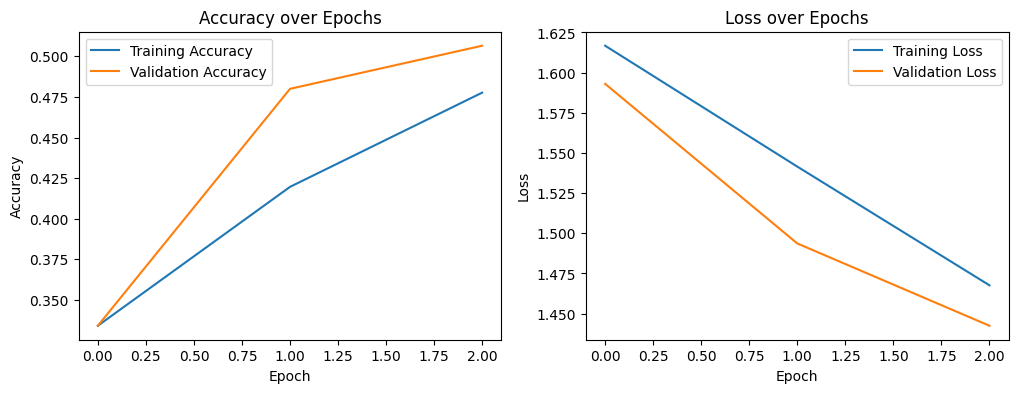

Accuracy: 51.0%
Loss: 1.43


In [278]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)